## **FINAL PROJECT - DSCI-552**













*   Name : **Shikhar Singh**
*   Github Username : **ShikharSingh167**
*   USC ID : **8943442373**














**NOTE to instructors** : This project was completed on Google Colab. To run this notebook, please upload this notebook to google colab and ensure the following files are present in your **'/content/drive/MyDrive'** folder:

*   data.zip
*   train_source_images.txt
*   val_source_images.txt
*   test_source_images.txt

Also, ensure you are connected to T4 GPU for optimum performance

## **Identification of Frost in Martian HiRISE Images**

(a) In this problem, we are trying to build a classifier that distinguishes images of
Martian terrain with frost. You can find the dataset in https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA.
This dataset was created to study Mars’ seasonal frost cycle and its role in the
planet’s climate and surface evolution over the past 2 billion years. The data helps
in identifying low-latitude frosted microclimates and their impact on climate.

### (b) **Data Exploration and Pre-processing**
i. Images (png files) and labels (json files) are organized in the data directory
by “subframes.” Subframes are individual 5120x5120 pixel images which are
crops of the original HiRISE images (often on the order of 50k x 10k pixels).
Individual subframes were annotated by the contributors and then sliced into
299x299 “tiles.” Each tile has an associated label for use in training ML
algorithms.

There are 214 subframes and a total of 119920 tiles. Each tile has annotations
which have been used to assign labels to the tiles ‘frost’ or ‘background.’

Each JSON file contains all the annotation information collected from human
annotators.

The following are relevant to the assignment:

Image tiles are organized into folders of ‘background’ and ‘frost’ classes (bi-
nary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.

ii. The dataset includes files for splitting the data into train, test and validation.
However, you will be provided by an improved version of those files when a
repo is created:


*   A. train source images.txt
*   B. test source images.txt
*   C. val source images.txt

iii. Each of these files contains the IDs of the high rise images (parent folders for
the subframes and tiles).

**Importing necessary packages**

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import random
import tensorflow as tf
from PIL import Image
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

**Mounting the google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Extracting contents from data.**

In [3]:
zip_path = '/content/drive/My Drive/data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')
os.listdir('/content/data/data')

['ESP_018946_2400_15360_20480_0_5120',
 'ESP_028501_1295_20480_25600_5120_10240',
 'ESP_062521_2450_5120_10240_20480_25600',
 'ESP_071080_2370_25600_30720_15360_20480',
 'ESP_072796_1295_10240_15360_5120_10240',
 'PSP_005315_1770_15360_20480_15360_20480',
 'ESP_066935_2230_15360_20480_0_5120',
 'ESP_057638_2230_10240_15360_10240_15360',
 'ESP_058933_2370_15360_20480_5120_10240',
 'PSP_009808_2400_51200_56320_20480_25600',
 'ESP_066956_2450_20480_25600_5120_10240',
 'ESP_061741_2435_5120_10240_10240_15360',
 'ESP_066104_2230_51200_56320_15360_20480',
 'ESP_024370_2445_56320_61440_10240_15360',
 'ESP_042279_1820_5120_10240_0_5120',
 'ESP_018951_1205_10240_15360_0_5120',
 'ESP_039175_1200_15360_20480_5120_10240',
 'ESP_011605_1170_10240_15360_10240_15360',
 'ESP_066956_2450_30720_35840_10240_15360',
 'ESP_066813_2360_15360_20480_5120_10240',
 'ESP_062177_2370_35840_40353_10240_15360',
 'PSP_009808_2400_20480_25600_25600_30720',
 'PSP_002033_1325_15360_20480_5120_10240',
 'ESP_019251_2385_

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

**Data preprocessing**

In [5]:
IMAGE_SIZE = (299, 299)
SEED = 17
data_head_dir = Path('/content/data/data')
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
len(subdirs)

414

In [7]:
len(src_image_ids)

414

In [8]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('drive/MyDrive/test_source_images.txt')


In [9]:
len(train_ids)

79

In [10]:
len(validate_ids)

18

In [11]:
len(test_ids)

18

In [12]:
# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [13]:
len(subdir_splits)

414

In [14]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        return img, 1 if label_str=='frost' else 0
    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    return X, y

In [15]:
def load_subdir_data(dir_path, image_size, seed=None):
    """Helper to create a TF dataset from each image subdirectory"""
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    loc_list = []
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list

**Splitting the dataset into test, train and validation data**

In [16]:
# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))


In [17]:
len(tf_data_train)

29679

In [18]:
len(tf_data_test)

12823

In [19]:
len(tf_data_val)

11286

**Function to ensure tensor size**

In [20]:
def set_shape(images, labels):
    images.set_shape([None, 299, 299, 3])
    labels.set_shape([None, 2])
    return images, labels

**Function to one-hot encode labels**

In [21]:
def one_hot_encoding(image, label):
    label = tf.one_hot(label, depth=2)
    return image, label

**Creating train, test and validation dataset tensors**

In [22]:
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_train = tf_dataset_train.map(one_hot_encoding)
tf_dataset_train = tf_dataset_train.map(set_shape)

In [23]:
tf_dataset_train

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [24]:
random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_val = tf_dataset_val.map(one_hot_encoding)
tf_dataset_val = tf_dataset_val.map(set_shape)


In [25]:
tf_dataset_val

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [26]:
random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_test = tf_dataset_test.map(one_hot_encoding)
tf_dataset_test = tf_dataset_test.map(set_shape)

In [27]:
tf_dataset_test

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

**Function to augment images and applying to the training dataset**

In [28]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

tf_dataset_train_augmented = tf_dataset_train.map(
    lambda x, y: augment(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

### **(c) Training CNN + MLP**
i. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

ii. Train a three-layer CNN followed by a dense layer on the data. Choose the
size of the kernels and depth of the layers and the number of neurons in
the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use
the softmax function, batch normalization3 and a dropout rate of 30%, L2
regularization, as well as ADAM optimizer. Use cross entropy loss. Train
for at least 20 epochs and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs.

iii. Report Precision, Recall, and F1 score for your model.

### **My Approach: Model Architecture**
#### **First CNN Layer**
- Conv2D: 32 filters, 3x3 kernel size, ReLU activation, same padding, L2 regularization (0.1)
- BatchNormalization
- MaxPooling2D: 2x2 pool size

#### **Second CNN Layer**
- Conv2D: 64 filters, 3x3 kernel size, ReLU activation, same padding, L2 regularization (0.1)
- BatchNormalization
- MaxPooling2D: 2x2 pool size

#### **Third CNN Layer**
- Conv2D: 128 filters, 3x3 kernel size, ReLU activation, same padding, L2 regularization (0.1)
- BatchNormalization
- MaxPooling2D: 2x2 pool size
- Flatten and Dense Layers

#### **Flatten**
- Dense: 128 units, ReLU activation, L2 regularization (0.1)
- Dropout: 30%
- Dense: 2 units, Softmax activation

#### **Model Compilation**
- Optimizer: Adam with a learning rate of 0.00001
- Loss Function: Categorical Crossentropy
- Metrics: Accuracy, Precision, Recall

#### **Training Settings**
- **Early Stopping**: Monitor validation loss, patience of 7 epochs
- **Model Checkpoint**: Save the best model based on minimum validation loss, verbose output
- **Training**: Train for up to 20 epochs with callbacks for early stopping and model checkpointing
- **Data**: Training with augmented data (tf_dataset_train_augmented), validation data (tf_dataset_val)
- **Batch_Size**: 32




**Defining model architecture as per specifications**

In [29]:
model = Sequential([
    # First CNN layer
    Conv2D(32, kernel_size=(3, 3),activation = relu, padding='same', input_shape=(299, 299, 3), kernel_regularizer=l2(0.1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second CNN layer
    Conv2D(64, kernel_size=(3, 3),activation =relu, padding='same', kernel_regularizer=l2(0.1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third CNN layer
    Conv2D(128, kernel_size=(3, 3),activation =relu, padding='same',kernel_regularizer=l2(0.1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.3),
    Dense(2, activation='softmax')
])


**Training the CNN + MLP model**

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_cnn.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 30.7041 - accuracy: 0.7533 - precision: 0.7533 - recall: 0.7533
Epoch 1: val_loss improved from inf to 23.40819, saving model to best_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



928/928 [==============================] - 369s 382ms/step - loss: 30.7041 - accuracy: 0.7533 - precision: 0.7533 - recall: 0.7533 - val_loss: 23.4082 - val_accuracy: 0.8487 - val_precision: 0.8487 - val_recall: 0.8487
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 18.7668 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059
Epoch 2: val_loss improved from 23.40819 to 14.98841, saving model to best_cnn.h5
928/928 [==============================] - 368s 396ms/step - loss: 18.7668 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - val_loss: 14.9884 - val_accuracy: 0.7660 - val_precision: 0.7660 - val_recall: 0.7659
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 12.3336 - accuracy: 0.8359 - precision: 0.8359 - recall: 0.8359
Epoch 3: val_loss improved from 14.98841 to 10.18356, saving model to best_cnn.h5
928/928

**Plotting Training and Validation Loss vs Number of Epochs**

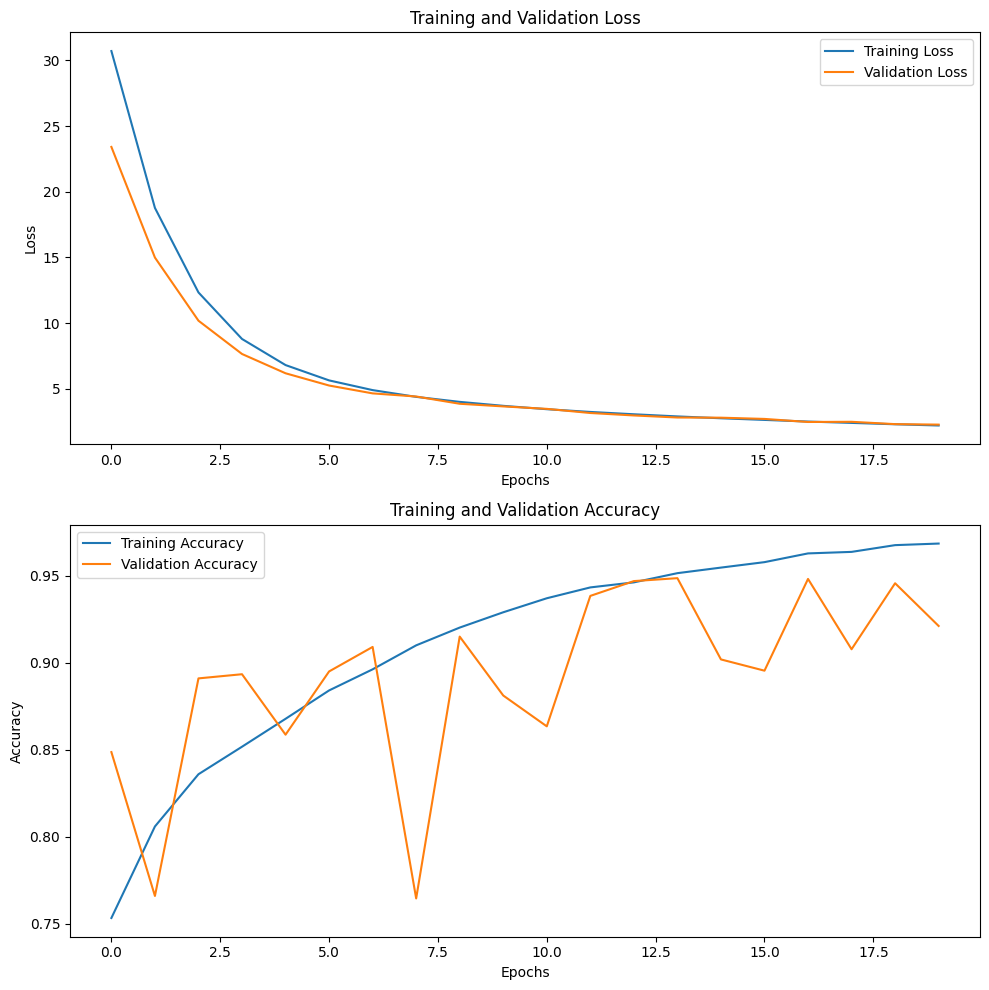

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Observations**
- Both training and validation loss decrease sharply at the beginning, indicating that the model is learning effectively.
- The training loss continues to decrease and plateau, suggesting the model is fitting well to the training data.
- The validation loss decreases alongside the training loss and begins to plateau, implying that the model is generalizing well to unseen data.
- There's no significant increase in validation loss, which indicates that overfitting is not occurring within the observed epochs.
- The training accuracy increases over time, suggesting that the model is getting better at predicting the correct labels for the training data.
- The validation accuracy fluctuates but generally increases, although not as smoothly as the training accuracy. This is common in training scenarios and could be due to the model encountering slightly different patterns in the validation data that it has not learned from the training data.
- The validation accuracy appears to be lower than the training accuracy, which is typical, but since the gap is not wide, it suggests good model generalization.
- There are some dips in validation accuracy, which might be due to the model encountering challenging examples or noise in the validation dataset.

**Loading the best model**

In [30]:
best_model = load_model('/content/best_cnn.h5')

#### **Evaluating the Model on Train, Test and Validation dataset**

In [31]:
from sklearn.metrics import classification_report

def model_evaluation(model, dataset, show_output=True):
  true_labels = []
  predicted_labels = []
  for img, lbl in dataset:
    predictions = model.predict(img, verbose=0)
    true_labels.extend(np.argmax(lbl.numpy(), axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))
  report = classification_report(true_labels,predicted_labels)
  return report

**CNN + MLP performance on Augmented Training Dataset**

In [34]:
train_augmented_report = model_evaluation(best_model, tf_dataset_train_augmented)

In [35]:
print(train_augmented_report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12235
           1       0.99      0.95      0.97     17444

    accuracy                           0.97     29679
   macro avg       0.96      0.97      0.97     29679
weighted avg       0.97      0.97      0.97     29679



**CNN + MLP performance on original Training Dataset**

In [32]:
train_report = model_evaluation(best_model, tf_dataset_train)

In [33]:
print(train_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     12235
           1       0.99      0.97      0.98     17444

    accuracy                           0.98     29679
   macro avg       0.98      0.98      0.98     29679
weighted avg       0.98      0.98      0.98     29679



**CNN + MLP performance on Validation Dataset**

In [36]:
val_report = model_evaluation(best_model, tf_dataset_val)

In [37]:
print(val_report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7654
           1       0.81      0.99      0.89      3632

    accuracy                           0.92     11286
   macro avg       0.90      0.94      0.91     11286
weighted avg       0.93      0.92      0.92     11286



**CNN + MLP performance on Testing Dataset**

In [38]:
test_report = model_evaluation(best_model, tf_dataset_test)

In [39]:
print(test_report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4418
           1       0.96      0.94      0.95      8405

    accuracy                           0.93     12823
   macro avg       0.92      0.93      0.92     12823
weighted avg       0.93      0.93      0.93     12823



#### **CNN+MLP Results - Macro Avg Scores**
- **Train - Augmented**
    - Precision = 0.96
    - Recall = 0.97
    - F1 Score = 0.97
    - Accuracy = 0.97
- **Train**
    - Precision = 0.98
    - Recall = 0.98
    - F1 Score = 0.98
    - Accuracy = 0.98
- **Validation**
    - Precision = 0.90
    - Recall = 0.94
    - F1 Score = 0.91
    - Accuracy = 0.92
- **Test**
    - Precision = 0.92
    - Recall = 0.93
    - F1 Score = 0.92
    - Accuracy = 0.93


#### **Observations**
- The CNN+MLP model exhibits strong performance on both validation and testing datasets with high accuracy, precision, recall, and F1-scores. 
- It demonstrates good generalization capabilities, as indicated by consistent metrics across both datasets. 
- There is a slight imbalance in precision and recall between the two classes, with class 'background' predictions being more precise and class 'frost' predictions having higher recall. 
- The similar performance metrics between validation and testing suggest that overfitting is unlikely, as an overfitted model would typically perform better on the validation set and see a drop in performance on the testing set

### **(d) Transfer Learning**
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train
them. In such cases, one usually uses transfer learning, which uses deep
learning models that are trained on very large datasets such as ImageNet
as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those fea-
tures can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and
the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement
layers. In this project, you will use pre-trained models (EfficientNetB0,
ResNet50, and VGG16). For these pre-trained networks, you will only train
the last fully connected layer, and will freeze all layers before them (i.e. we
do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization 5 and a dropout rate of 30% as well as ADAM
optimizer. Use cross entropy loss. You can try any batch size, but a batch
size of 8 seems reasonable.

iv. Train using the features calculated by networks (EfficientNetB0, ResNet50,
and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early
stopping using the validation set. Keep the network parameters that have the
lowest validation error. Plot the training and validation errors vs. epochs.

v. Report Precision, Recall, and F1 score for your model.

vi. Compare the results of transfer learning with those of CNN + MLP model
and explain them.

**Splitting the dataset into test, train and validation data with new batch size**

In [47]:
# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))


In [48]:
len(tf_data_train)

29679

In [49]:
len(tf_data_test)

12823

In [50]:
len(tf_data_val)

11286

**Creating train, test and validation dataset tensors**

In [53]:
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_train = tf_dataset_train.map(one_hot_encoding)
tf_dataset_train = tf_dataset_train.map(set_shape)

In [54]:
tf_dataset_train

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [55]:
random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_val = tf_dataset_val.map(one_hot_encoding)
tf_dataset_val = tf_dataset_val.map(set_shape)


In [56]:
tf_dataset_val

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [57]:
random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)
tf_dataset_test = tf_dataset_test.map(one_hot_encoding)
tf_dataset_test = tf_dataset_test.map(set_shape)

In [58]:
tf_dataset_test

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

**augmenting images and creating a new augmented training dataset**

In [59]:
tf_dataset_train_augmented = tf_dataset_train.map(
    lambda x, y: augment(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

### **EfficientNetB0 model**

#### **My Approach - Model Configuration**
- **Base Model**: EfficientNetB0 pre-trained on ImageNet.
- **Trainable**: Base model layers are frozen (not trainable) to preserve the pre-trained features.
- **Custom Layers Added**:
    - **GlobalAveragePooling2D**: Reduces the spatial dimensions to a vector.
    - **Dense Layer**: 1024 units, ReLU activation, L2 regularization with a factor of 0.1.
    - **BatchNormalization**: Applied after the dense layer.
    - **Dropout**: Set to 30% to reduce overfitting by randomly setting input units to 0 at each update during training.
    - **Output Layer**: Dense layer with 2 units (assuming binary classification) with a softmax activation function.

**Compilation Settings**:
- **Optimizer**: Adam with a learning rate of 0.00001.
- **Loss Function**: Categorical crossentropy.
- **Metrics**: Accuracy, Precision, and Recall.

**Training Configuration**:
- **EarlyStopping Callback**: Monitor validation loss with a patience of 7 epochs before stopping.
- **ModelCheckpoint Callback**: Save the best model based on the minimum validation loss.
- **Verbose**: Set to 1 for the ModelCheckpoint to print out when a better model is saved.
- **Epochs**: The model is set to train for a maximum of 20 epochs.
- **Data**: Trained on an augmented training dataset (tf_dataset_train_augmented) with a separate validation dataset (tf_dataset_val).
- **Batch_Size**: 8

**Loading the EfficientNetB0 model**

In [60]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained model
base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


**Training the model**

In [61]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_enB0_v2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
3710/3710 [==============================] - ETA: 0s - loss: 59.5897 - accuracy: 0.8234 - precision_2: 0.8234 - recall_2: 0.8234
Epoch 1: val_loss improved from inf to 24.89962, saving model to best_enB0_v2.h5
3710/3710 [==============================] - 168s 43ms/step - loss: 59.5897 - accuracy: 0.8234 - precision_2: 0.8234 - recall_2: 0.8234 - val_loss: 24.8996 - val_accuracy: 0.8434 - val_precision_2: 0.8434 - val_recall_2: 0.8434
Epoch 2/20
3708/3710 [============================>.] - ETA: 0s - loss: 13.5229 - accuracy: 0.8983 - precision_2: 0.8983 - recall_2: 0.8983
Epoch 2: val_loss improved from 24.89962 to 7.25969, saving model to best_enB0_v2.h5
3710/3710 [==============================] - 159s 43ms/step - loss: 13.5198 - accuracy: 0.8982 - precision_2: 0.8982 - recall_2: 0.8982 - val_loss: 7.2597 - val_accuracy: 0.8646 - val_precision_2: 0.8646 - val_recall_2: 0.8646
Epoch 3/20
3710/3710 [==============================] - ETA: 0s - loss: 4.9373 - accuracy: 0.9135 -

**Plotting Training and Validation Loss vs Number of Epochs**

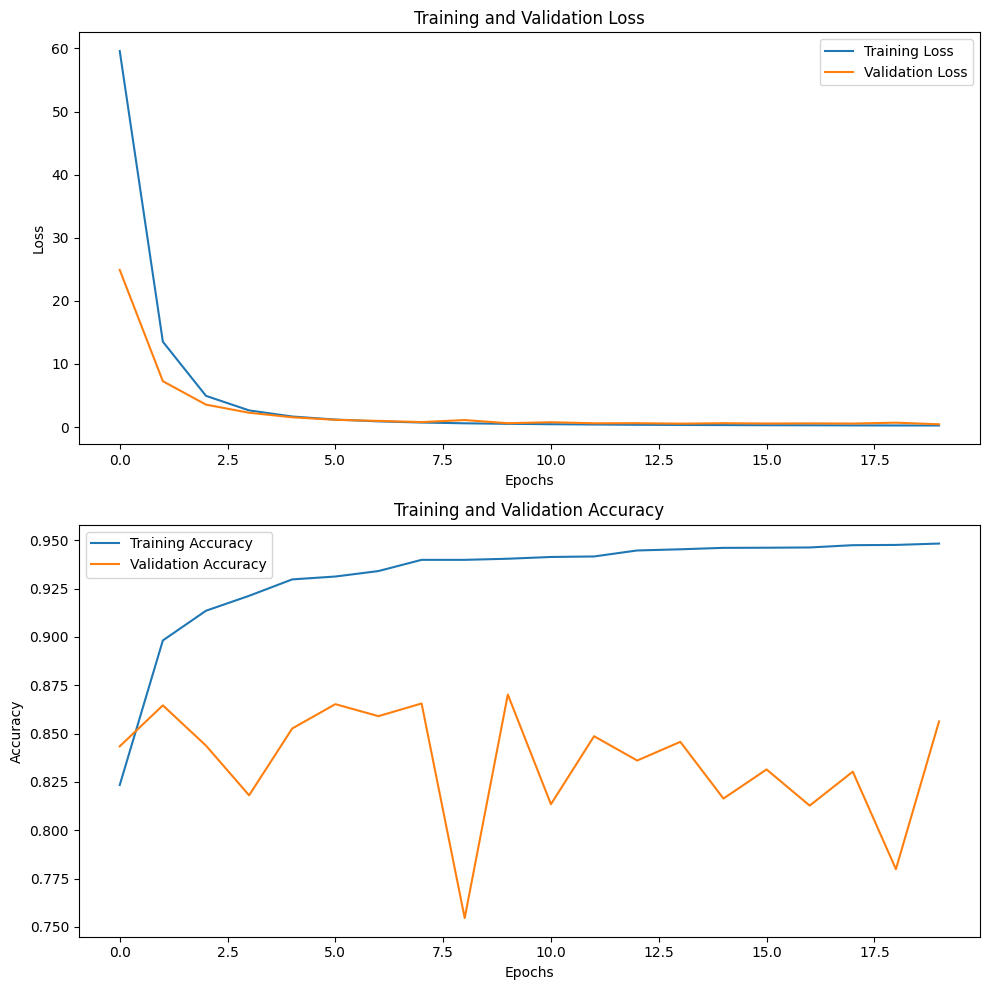

In [62]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Observations**
- The training and validation loss both decrease sharply and then level off, indicating that the model is learning and improving its predictions over epochs.
- The losses converge, suggesting that the model is not overfitting significantly since the validation loss follows the training loss closely.
- The training accuracy increases and reaches a plateau, showing that the model performs consistently on the training data.
- The validation accuracy is volatile and generally lower than the training accuracy, indicating the model may face some challenges generalizing to the validation data.
- Despite fluctuations, the validation accuracy doesn't show a downward trend, so there's no clear sign of overfitting.

**Loading the best model**

In [63]:
best_model = load_model('/content/best_enB0_v2.h5')

#### **Evaluating the Model on Train, Test and Validation dataset**

**EfficientNetB0 performance on Augmented Training Dataset**

In [65]:
train_augmented_report = model_evaluation(best_model, tf_dataset_train_augmented)

In [66]:
print(train_augmented_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12235
           1       0.98      0.99      0.99     17444

    accuracy                           0.98     29679
   macro avg       0.98      0.98      0.98     29679
weighted avg       0.98      0.98      0.98     29679



**EfficientNetB0 performance on original Training Dataset**

In [67]:
train_report = model_evaluation(best_model, tf_dataset_train)

In [68]:
print(train_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12235
           1       0.98      0.99      0.99     17444

    accuracy                           0.99     29679
   macro avg       0.99      0.98      0.98     29679
weighted avg       0.99      0.99      0.98     29679



**EfficientNetB0 performance on Validation Dataset**

In [69]:
val_report = model_evaluation(best_model, tf_dataset_val)

In [70]:
print(val_report)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7654
           1       0.70      0.97      0.81      3632

    accuracy                           0.86     11286
   macro avg       0.84      0.89      0.85     11286
weighted avg       0.89      0.86      0.86     11286



**EfficientNetB0 performance on Testing Dataset**

In [71]:
test_report = model_evaluation(best_model, tf_dataset_test)

In [72]:
print(test_report)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4418
           1       0.94      0.98      0.96      8405

    accuracy                           0.94     12823
   macro avg       0.94      0.93      0.93     12823
weighted avg       0.94      0.94      0.94     12823



#### **EffiecientNetB0 Results - Macro Avg Scores**
- **Train - Augmented**
    - Precision = 0.98
    - Recall = 0.98
    - F1 Score = 0.98
    - Accuracy = 0.98
- **Train**
    - Precision = 0.99
    - Recall = 0.98
    - F1 Score = 0.98
    - Accuracy = 0.99
- **Validation**
    - Precision = 0.84
    - Recall = 0.89
    - F1 Score = 0.85
    - Accuracy = 0.86
- **Test**
    - Precision = 0.94
    - Recall = 0.93
    - F1 Score = 0.93
    - Accuracy = 0.94

#### **Observations**
- The EfficientNetB0 model demonstrates strong and balanced performance, with high precision and recall across both validation and testing datasets. - It shows a slight preference for recall over precision on the validation set, indicating more false positives for class 'frost', but this is less pronounced in the testing set where both metrics are high. 
- Overall, the model is accurate (above 85% on validation set and 94% on test) and generalizes well to new data.

### **ResNet50 model**

#### **My Approach - Model Configuration**
- **Base Model**: ResNet50 pre-trained on ImageNet.
- **Trainable**: Base model layers are frozen (not trainable) to preserve the pre-trained features.
- **Custom Layers Added**:
  - **GlobalAveragePooling2D**: Reduces the spatial dimensions to a vector.
  - **Dense Layer**: 1024 units, ReLU activation, L2 regularization with a factor of 0.1.
  - **BatchNormalization**: Applied after the dense layer.
  - **Dropout**: Set to 30% to reduce overfitting by randomly setting input units to 0 at each update during training.
  - **Output Layer**: Dense layer with 2 units (assuming binary classification) with a softmax activation function.

**Compilation Settings**:
- **Optimizer**: Adam with a learning rate of 0.00001.
- **Loss Function**: Categorical crossentropy.
- **Metrics**: Accuracy, Precision, and Recall.

**Training Configuration**:
- **EarlyStopping Callback**: Monitor validation loss with a patience of 7 epochs before stopping.
- **ModelCheckpoint Callback**: Save the best model based on the minimum validation loss, named 'best_rn50_v2.h5'.
- **Verbose**: Set to 1 for the ModelCheckpoint to print out when a better model is saved.
- **Epochs**: The model is set to train for a maximum of 20 epochs.
- **Data**: Trained on an augmented training dataset (`tf_dataset_train_augmented`) with a separate validation dataset (`tf_dataset_val`).
- **Batch_Size**: 8


**Loading the ResNet50 model**

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)



94765736/94765736 [==============================] - 3s 0us/step


**Training the model**

In [32]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_rn50_v2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
3710/3710 [==============================] - ETA: 0s - loss: 60.0983 - accuracy: 0.8496 - precision_1: 0.8496 - recall_1: 0.8496
Epoch 1: val_loss improved from inf to 19.05679, saving model to best_rn50_v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



3710/3710 [==============================] - 196s 51ms/step - loss: 60.0983 - accuracy: 0.8496 - precision_1: 0.8496 - recall_1: 0.8496 - val_loss: 19.0568 - val_accuracy: 0.8592 - val_precision_1: 0.8592 - val_recall_1: 0.8592
Epoch 2/20
3708/3710 [============================>.] - ETA: 0s - loss: 9.8406 - accuracy: 0.9199 - precision_1: 0.9199 - recall_1: 0.9199
Epoch 2: val_loss improved from 19.05679 to 5.65250, saving model to best_rn50_v2.h5
3710/3710 [==============================] - 190s 51ms/step - loss: 9.8385 - accuracy: 0.9199 - precision_1: 0.9199 - recall_1: 0.9199 - val_loss: 5.6525 - val_accuracy: 0.8366 - val_precision_1: 0.8366 - val_recall_1: 0.8366
Epoch 3/20
3710/3710 [==============================] - ETA: 0s - loss: 3.9646 - accuracy: 0.9359 - precision_1: 0.9359 - recall_1: 0.9359
Epoch 3: val_loss improved from 5.65250 to 3.40193, sa

**Plotting Training and Validation Loss vs Number of Epochs**

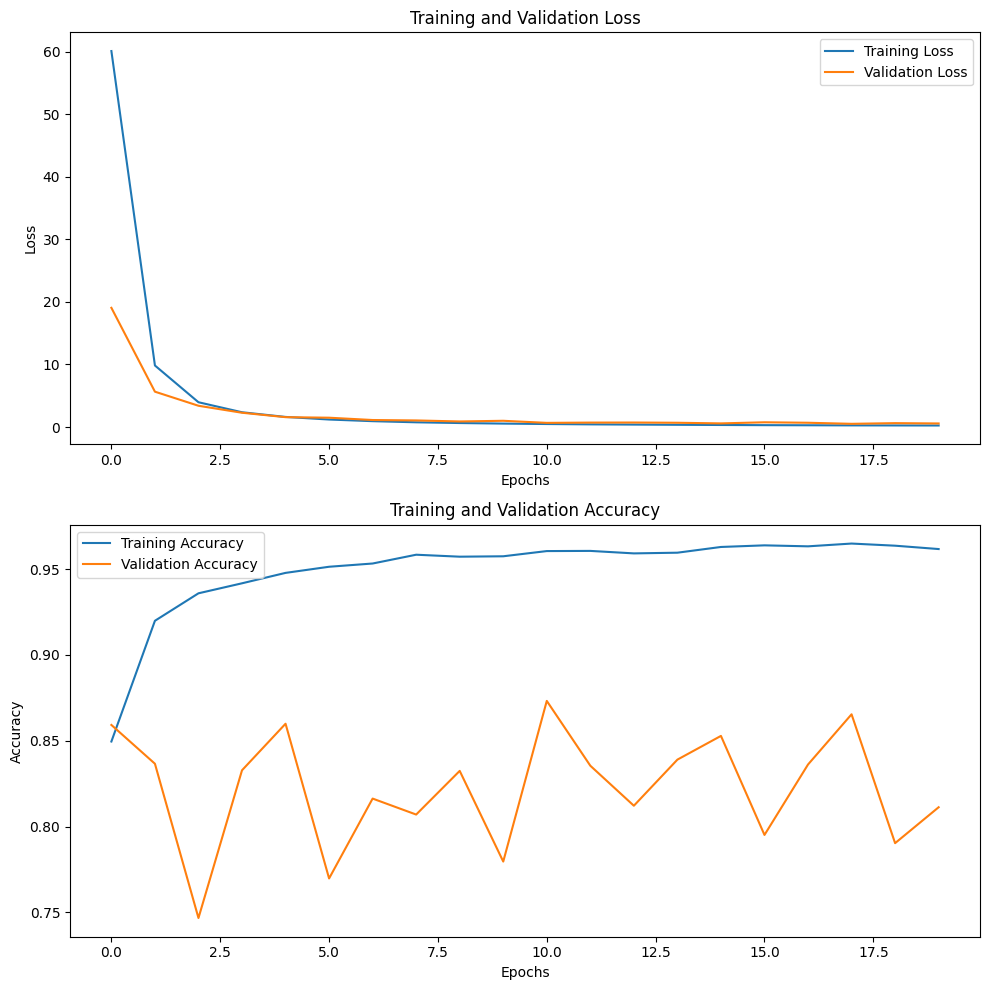

In [33]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Observations**
- Both training and validation loss decrease significantly at the start and then plateau, indicating the model is learning and beginning to converge.
- The validation loss closely tracks the training loss, suggesting the model is generalizing well without overfitting.
- The training accuracy quickly rises and levels off, indicating the model is consistently performing well on the training data.
- The validation accuracy shows greater fluctuation but generally trends upwards, which may suggest some variability in how the model handles the validation data across epochs. This could be due to the model encountering different features in the validation set that were not present in the training set
- There is no apparent overfitting within the observed epoch range, as the validation loss decreases in tandem with the training loss.

**Loading the best model**

In [34]:
best_model = load_model('/content/best_rn50_v2.h5')

**Evaluating the Model on Train, Test and Validation dataset**

**ResNet50 performance on Augmented Training Dataset**

In [36]:
train_augmented_report = model_evaluation(best_model, tf_dataset_train_augmented)

In [37]:
print(train_augmented_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12235
           1       0.99      0.99      0.99     17444

    accuracy                           0.99     29679
   macro avg       0.99      0.99      0.99     29679
weighted avg       0.99      0.99      0.99     29679



**ResNet50 performance on original Training Dataset**

In [38]:
train_report = model_evaluation(best_model, tf_dataset_train)

In [39]:
print(train_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12235
           1       0.99      0.99      0.99     17444

    accuracy                           0.99     29679
   macro avg       0.99      0.99      0.99     29679
weighted avg       0.99      0.99      0.99     29679



**ResNet50 performance on Validation Dataset**

In [40]:
val_report = model_evaluation(best_model, tf_dataset_val)

In [41]:
print(val_report)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      7654
           1       0.71      0.99      0.83      3632

    accuracy                           0.87     11286
   macro avg       0.85      0.90      0.86     11286
weighted avg       0.90      0.87      0.87     11286



**ResNet50 performance on Testing Dataset**

In [42]:
test_report = model_evaluation(best_model, tf_dataset_test)

In [43]:
print(test_report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      4418
           1       0.93      0.98      0.96      8405

    accuracy                           0.94     12823
   macro avg       0.95      0.92      0.93     12823
weighted avg       0.94      0.94      0.94     12823



#### **ResNet50 Results - Macro Avg Scores**
- **Train - Augmented**
    - Precision = 0.99
    - Recall = 0.99
    - F1 Score = 0.99
    - Accuracy = 0.99
- **Train**
    - Precision = 0.99
    - Recall = 0.99
    - F1 Score = 0.99
    - Accuracy = 0.99
- **Validation**
    - Precision = 0.85
    - Recall = 0.90
    - F1 Score = 0.86
    - Accuracy = 0.87
- **Test**
    - Precision = 0.95
    - Recall = 0.92
    - F1 Score = 0.93
    - Accuracy = 0.94

#### **Observations**
- The ResNet50 model demonstrates high precision and recall across both validation and testing datasets, with particularly strong performance on the testing set.
- This is indicated by high accuracy (0.94) and balanced F1-scores (0.91-0.96). 
The model shows a better predictive capability for class 'frost' on the testing dataset, suggesting effective generalization and learning.
- On the validation set precision is lower for class 'frost' at 0.71, with a high recall of 0.99, which means the model has more false positives for class 'frost', but it identifies nearly all actual class 'frost' instances.

### **VGG16 model**

#### **My Approach - Model Configuration**
- **Base Model**: VGG16 pre-trained on ImageNet.
- **Trainable**: Base model layers are frozen (not trainable) to preserve the pre-trained features.
- **Custom Layers Added**:
  - **GlobalAveragePooling2D**: Reduces the spatial dimensions to a vector.
  - **Dense Layer**: 1024 units, ReLU activation, L2 regularization with a factor of 0.1.
  - **BatchNormalization**: Applied after the dense layer.
  - **Dropout**: Set to 30% to reduce overfitting by randomly setting input units to 0 at each update during training.
  - **Output Layer**: Dense layer with 2 units (assuming binary classification) with a softmax activation function.

**Compilation Settings**:
- **Optimizer**: Adam with a learning rate of 0.00001.
- **Loss Function**: Categorical crossentropy.
- **Metrics**: Accuracy, Precision, and Recall.

**Training Configuration**:
- **EarlyStopping Callback**: Monitor validation loss with a patience of 7 epochs before stopping.
- **ModelCheckpoint Callback**: Save the best model based on the minimum validation loss, named 'best_vgg16_v2.h5'.
- **Verbose**: Set to 1 for the ModelCheckpoint to print out when a better model is saved.
- **Epochs**: The model is set to train for a maximum of 20 epochs.
- **Data**: Trained on an augmented training dataset (`tf_dataset_train_augmented`) with a separate validation dataset (`tf_dataset_val`).
- **Batch_Size**: 8


**Loading the VGG16 model**

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 0s 0us/step


**Training the model**

In [30]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_vgg16_v2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    tf_dataset_train_augmented,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
3710/3710 [==============================] - ETA: 0s - loss: 38.6500 - accuracy: 0.7587 - precision: 0.7587 - recall: 0.7587
Epoch 1: val_loss improved from inf to 18.83339, saving model to best_vgg16_v2.h5
3710/3710 [==============================] - 233s 60ms/step - loss: 38.6500 - accuracy: 0.7587 - precision: 0.7587 - recall: 0.7587 - val_loss: 18.8334 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 0.7510
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3710/3710 [==============================] - ETA: 0s - loss: 10.9503 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502
Epoch 2: val_loss improved from 18.83339 to 6.59694, saving model to best_vgg16_v2.h5
3710/3710 [==============================] - 214s 58ms/step - loss: 10.9503 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - val_loss: 6.5969 - val_accuracy: 0.7702 - val_precision: 0.7702 - val_recall: 0.7702
Epoch 3/20
3709/3710 [============================>.] - ETA: 0s - loss: 4.7796 - accuracy: 0.8749 - precision: 0.8749 - recall: 0.8749
Epoch 3: val_loss improved from 6.59694 to 3.91481, saving model to best_vgg16_v2.h5
3710/3710 [==============================] - 213s 57ms/step - loss: 4.7796 - accuracy: 0.8748 - precision: 0.8748 - recall: 0.8748 - val_loss: 3.9148 - val_accuracy: 0.7477 - val_precision: 0.7477 - val_recall: 0.7477
Epoch 4/20
3710/3710 [==============================] - ETA: 0s - loss: 2.9767 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.88

Plotting Training and Validation Loss vs Number of Epochs

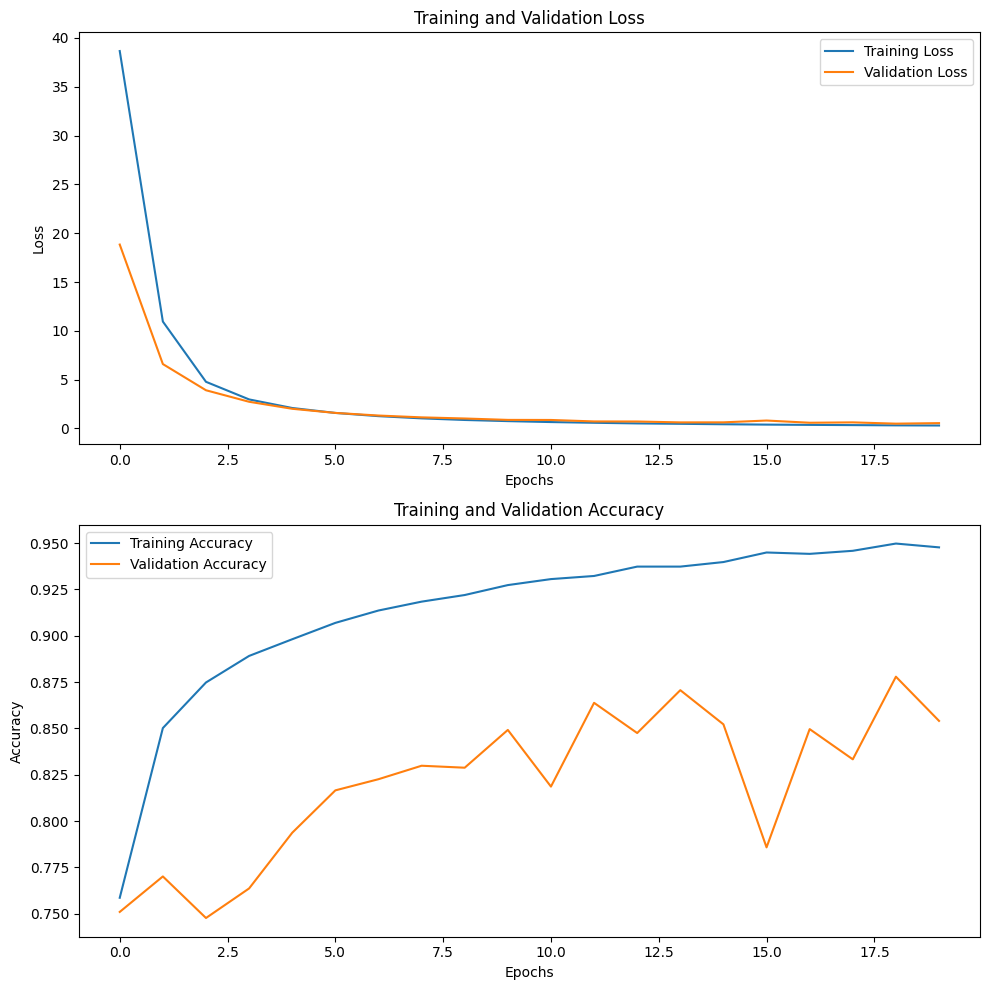

In [31]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Observations**
- The training loss decreases significantly and levels off, indicating that the model is learning from the training data.
- The validation loss decreases alongside the training loss and also levels off, suggesting that the model is generalizing well to unseen data without overfitting.
- The training accuracy increases steadily, reaching a plateau, which is a sign of good learning on the training data.
- The validation accuracy increases but with fluctuations, showing some variability in the model's performance on the validation set across different epochs.
- The fluctuations in validation accuracy could suggest that the validation data may contain some harder-to-predict samples


**Loading the best model**

In [32]:
best_model = load_model('/content/best_vgg16_v2.h5')

#### **Evaluating the Model on Train, Test and Validation dataset**

**VGG16 performance on Augmented Training Dataset**

In [34]:
train_augmented_report = model_evaluation(best_model, tf_dataset_train_augmented)

In [35]:
print(train_augmented_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12235
           1       0.98      0.98      0.98     17444

    accuracy                           0.98     29679
   macro avg       0.98      0.98      0.98     29679
weighted avg       0.98      0.98      0.98     29679



**VGG16 performance on original Training Dataset**

In [36]:
train_report = model_evaluation(best_model, tf_dataset_train)

In [37]:
print(train_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12235
           1       0.99      0.99      0.99     17444

    accuracy                           0.99     29679
   macro avg       0.99      0.99      0.99     29679
weighted avg       0.99      0.99      0.99     29679



**VGG16 performance on Validation Dataset**

In [38]:
val_report = model_evaluation(best_model, tf_dataset_val)

In [39]:
print(val_report)

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7654
           1       0.74      0.95      0.83      3632

    accuracy                           0.88     11286
   macro avg       0.86      0.90      0.87     11286
weighted avg       0.90      0.88      0.88     11286



**VGG16 performance on Testing Dataset**

In [40]:
test_report = model_evaluation(best_model, tf_dataset_test)

In [41]:
print(test_report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4418
           1       0.96      0.97      0.97      8405

    accuracy                           0.95     12823
   macro avg       0.95      0.95      0.95     12823
weighted avg       0.95      0.95      0.95     12823



#### **VGG16 Results - Macro Avg Scores**
- **Train - Augmented**
    - Precision = 0.98
    - Recall = 0.98
    - F1 Score = 0.98
    - Accuracy = 0.98
- **Train**
    - Precision = 0.99
    - Recall = 0.99
    - F1 Score = 0.99
    - Accuracy = 0.99
- **Validation**
    - Precision = 0.86
    - Recall = 0.90
    - F1 Score = 0.87
    - Accuracy = 0.88
- **Test**
    - Precision = 0.95
    - Recall = 0.95
    - F1 Score = 0.95
    - Accuracy = 0.95

#### **Observations**
- The model shows an impressive ability to generalize from the training data to unseen data, with high accuracy and F1-scores on the testing set compared to the validation set.
- The consistency in high performance metrics (precision, recall, F1-score) from validation to testing suggests that the model is robust and reliable.
- The improvement from validation to testing performance, especially in precision for class 1, might indicate differences in the data distribution between the two sets or that the validation set includes more challenging or diverse examples.

## **COMPARING RESULTS**

| Model            | DataSet        | Macro Avg Precision | Macro Avg Recall | Macro Avg F1 Score | Accuracy |
|------------------|--------------------|-----------|--------|----------|----------|
| CNN+MLP          | Train - Augmented  | 0.96      | 0.97   | 0.97     | 0.97     |
| CNN+MLP          | Train              | 0.98      | 0.98   | 0.98     | 0.98     |
| CNN+MLP          | Validation         | 0.90      | 0.94   | 0.91     | 0.92     |
| CNN+MLP          | Test               | 0.92      | 0.93   | 0.92     | 0.93     |
| EfficientNetB0   | Train - Augmented  | 0.98      | 0.98   | 0.98     | 0.98     |
| EfficientNetB0   | Train              | 0.99      | 0.98   | 0.98     | 0.99     |
| EfficientNetB0   | Validation         | 0.84      | 0.89   | 0.85     | 0.86     |
| EfficientNetB0   | Test               | 0.94      | 0.93   | 0.93     | 0.94     |
| ResNet50         | Train - Augmented  | 0.99      | 0.99   | 0.99     | 0.99     |
| ResNet50         | Train              | 0.99      | 0.99   | 0.99     | 0.99     |
| ResNet50         | Validation         | 0.85      | 0.90   | 0.86     | 0.87     |
| ResNet50         | Test               | 0.95      | 0.92   | 0.93     | 0.94     |
| VGG16            | Train - Augmented  | 0.98      | 0.98   | 0.98     | 0.98     |
| VGG16            | Train              | 0.99      | 0.99   | 0.99     | 0.99     |
| VGG16            | Validation         | 0.86      | 0.90   | 0.87     | 0.88     |
| VGG16            | Test               | 0.95      | 0.95   | 0.95     | 0.95     |


## **GENERAL OBSERVATIONS**:

- All models perform exceptionally well on the training set, with most metrics above 0.95. This is expected as models tend to perform best on the data they were trained on.
- The augmented training data, which is typically used to introduce variability and prevent overfitting, shows slightly lower performance than the non-augmented training data for the CNN+MLP and VGG16 models, indicating that augmentation introduces a tougher, more varied training scenario.
- The test scores are slightly lower than the training scores across all models, which is normal since the test set consists of unseen data.

#### **CNN + MLP model**:
Shows robust performance across all metrics, indicating good generalization. However, the validation and test scores are lower than the training scores.

#### **EfficientNetB0**:
This model has the highest precision and accuracy on the training set but shows a significant drop in performance on the validation set, particularly in precision. Despite the drop, the test scores recover somewhat, indicating that the model may still generalize well on completely unseen data.

#### **ResNet50**:
Exhibits the highest scores in the training phase, suggesting it has learned the training data very well, possibly better than the other models.
The validation and test scores, while lower than the training scores, are still high. However, the drop from training to validation is notable,yet the model performs well on the test set

#### **VGG16**:
The VGG16 model shows very consistent high performance on training data, and like the others, a drop in validation scores. However, it has the highest test scores across all metrics, indicating strong generalization capabilities.


### **Model Comparison**:

- **Training Phase**: ResNet50 seems to be the most effective model in learning from the training data with the highest F1 score and accuracy.
- **Validation Phase**: Here, the models show their ability to generalize to new data. VGG16 shows the least drop in performance from training to validation, suggesting it may be the most robust to overfitting.
- **Test Phase**: VGG16 again shows the highest scores, which indicates that it generalizes the best out of all the models to unseen data.

### **Overall Conclusions**:
- VGG16 appears to be the most balanced model in terms of generalizing from training to unseen data while maintaining high performance across all metrics.
- ResNet50, despite its high training scores, doesn’t seem to generalize as well as VGG16, although it still performs strongly.
- EfficientNetB0 shows a drop from training to validation scores, but recovers on the test set.
- CNN+MLP, while robust, does not achieve the same high scores as the other models on the test set.



## **CNN+MLP vs Transfer Learning** 

#### **Complexity and Depth:**

- CNN+MLP is  a simpler model compared to the pre-built architectures ResNet50, EfficientNetB0, and VGG16. These transfer learning models are deeper and more complex, designed to capture a wide variety of features from very large datasets (like ImageNet).
- Transfer learning models are pre-trained on a massive amount of data and fine-tuned for specific tasks, which often gives them an edge in terms of feature extraction capabilities.

#### **Training Data:**

- The CNN+MLP model might require more data to reach the same level of accuracy as the transfer learning models if it is trained from scratch.
Transfer learning models leverage their pre-trained weights to achieve high accuracy with potentially less training data because they have already learned a lot of feature representations.

#### **Performance:**

- From the results, CNN+MLP shows competitive performance but generally falls behind the transfer learning models on the test set, which is critical for evaluating generalization capabilities.
- The transfer learning models, particularly VGG16, exhibit stronger performance on the test set, indicating better generalization to unseen data.
- However, since the difference in performance between CNN+MLP and Transfer Learning is minimal, CNN+MLP can be a good candidate for this particular task

#### **Overfitting:**

- CNN+MLP seems to have a smaller gap between training and validation/test scores, which could mean it’s less prone to overfitting compared to some of the transfer learning models. This can be an indication that the model complexity is more aligned with the problem complexity and the amount of available training data.
- Transfer learning models, particularly EfficientNetB0, show a noticeable drop in performance from training to validation, suggesting that the model may be too complex and thus overfitting to the training data. However, because they have so many parameters, they can sometimes capture noise along with the signal during training.


#### **General Observations:**

- **Generalization**: Transfer learning models generally have a better ability to generalize, as indicated by the higher test scores, due to the vast variety of features they have already learned.
- **Adaptability**: Transfer learning models can be adapted to a wide range of tasks and datasets, which makes them very versatile if you need to work on different types of problems.

- **Conclusion**:
- While the CNN+MLP model is a strong contender and may be easier to train and iterate, the transfer learning models, with their depth and pre-trained knowledge, generally provide better performance and generalization capabilities, especially when fine-tuned correctly. 
- However, given only a minor increase in performance in Transfer Learning models from our CNN+MLP model, CNN+MLP is a good choice for this dataset for binary image classification